## FACET2e BMAD simple example

You will need to install pytao, BMAD, and openpmd-beamphysics (as well as standard libraries like numpy, matplotlib and pandas)

 conda install -c conda-forge bmad
 conda install -c conda-forge pytao, openpmd-beamphysics

In [1]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles

#needed for lattice_init
#%env FACET2_LATTICE /u/ar/dcesar/notebooks/facet_bmad
%env FACET2_LATTICE /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample
print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 

env: FACET2_LATTICE=/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample
Make sure enviornment was set!:   /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample


In [2]:
colorlist=['#982649', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']

def floorplan_sorter(ele):
    """
    ele is an element of a pandas dictionary made from the bmad floorplan (made to look like an elegant floorplan from my "elegant_helpers" file). This sorter parses the columns to make a "patch" for plotting purposes. See floorplan_patches().
    """
    if ele['ds']==0:
        ele['ds']=0.05
    s0=float(ele['s'])-float(ele['ds'])
    x=float(ele['X'])*2-0.5
    
    if (re.search('DRIF',ele.ElementType.upper())!=None)|(ele.ElementType.upper()=='MARK'):
        patchColor=None
        patch=None
    elif (re.search('BEND',ele.ElementType.upper())!=None)|(re.search('KICK',ele.ElementType.upper())!=None):
        patchColor='r'
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif re.search('XL',ele.ElementName.upper())!=None:
        patchColor=colorlist2[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'QUAD' in ele.ElementType.upper():
        patchColor=colorlist[2]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'SEXT' in ele.ElementType.upper():
        patchColor="#204337"
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'RFCW' in ele.ElementType.upper() or 'CAV' in ele.ElementType.upper():
        string_lst=['L3_10_50','L3_10_25','L2_10_25','L2_10_50','X1_Xband','L1_10_25','L1_9_25','L1_9_50'] #nonzero voltage
        if re.findall(r"(?=("+'|'.join(string_lst)+r"))",ele.ElementName)!=None:
            patchColor="#CD7F32"
            patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=0.5,color=patchColor,lw=0,ls=None)
    elif re.search('^UM',ele.ElementName)!=None:
        patchColor=colorlist[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    else:
        patchColor=None
        patch=None
        
    return patch

def floorplan_patches(floorplan,zbounds=None):
    """
    This function returns a list of patches to be plotted (patches) and a list of patches for the legend (leg_patches). If zbounds=[zmin,zmax] is given then the plot is restricted to the bounds. 
    
    Useage:
    
    fp=SDDS(0)
    fp.load(LCLS2scS.flr)
    __,floorplan=sdds2pd(fp)
    patches,leg_patches=flooplan_patches(floorplan,[3425,3750])
    """
    if zbounds==None:
        zbounds=[flooplan['s'].min(),flooplan['s'].max()]
    sFloor=floorplan.s.astype(dtype=float);
    sFloor=sFloor.values
    ii=0;
    patches=[];
    for index, ele in (floorplan.iloc[(sFloor>zbounds[0])&(sFloor<zbounds[1])]).iterrows():
        patches.append(floorplan_sorter(ele))
    
    quad_patch = mpatches.Patch(color=colorlist[2], label='Quad')
    sext_patch = mpatches.Patch(color="#204337", label='Linac')
    bend_patch = mpatches.Patch(color='red', label='Bend')
    leg_patches=[quad_patch,sext_patch,bend_patch];
    return patches,leg_patches

In [3]:
def floorplan_plot(ax_fp,floorplan,zmin=0,zmax=2000):  
    """
    This function plots "patches" for basic elements in the lattice. This can help identify what you're looking at in a "z-plot".
    """
    
    patches,leg_patches=floorplan_patches(floorplan,[zmin,zmax])

    for p in patches:
        if p!=None:
            ax_fp.add_patch(p)

    ax_fp.plot((zmin,zmax),(0,0),'k',alpha=0.0)
    ax_fp.tick_params(axis='x',direction='out',length=15,width=6,color='k',bottom=True)
    plt.yticks([])
    #ax_fp.set_ylim([-3,1])
    ax_fp.set_xlim([zmin,zmax])
    return ax_fp
    
def format_longitudinal_plot(fig):
    """
    This function helps format a "z-plot" by providing axes for the main plot and for the a floorplan_plot. It also plots the floorplan.
    """
    outer_grid=fig.add_gridspec(5,1,hspace=0)
    ax=fig.add_subplot(outer_grid[0:4,:])
    ax_fp=fig.add_subplot(outer_grid[4,:], sharex = ax)
    floorplan_plot(ax_fp,floorplan)
    plt.sca(ax)
    
    return ax, ax_fp 

# Start tao

In [4]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 

## Plot single particle twiss

In [5]:
elements=tao.lat_ele_list();
#tao.lat_list(elements[0],'ElementType')
tao.ele_gen_attribs(elements[0])

{'INHERIT_FROM_FORK': False,
 'SPIN_DN_DPZ_X': 0.0,
 'units#SPIN_DN_DPZ_X': '',
 'SPIN_DN_DPZ_Y': 0.0,
 'units#SPIN_DN_DPZ_Y': '',
 'SPIN_DN_DPZ_Z': 0.0,
 'units#SPIN_DN_DPZ_Z': '',
 'CMAT_11': 0.0,
 'units#CMAT_11': '',
 'CMAT_12': 0.0,
 'units#CMAT_12': '',
 'CMAT_21': 0.0,
 'units#CMAT_21': '',
 'CMAT_22': 0.0,
 'units#CMAT_22': '',
 'MODE_FLIP': False,
 'P0C_START': 5978200.40422692,
 'units#P0C_START': 'eV',
 'E_TOT_START': 6000000.0,
 'units#E_TOT_START': 'eV',
 'P0C': 5978200.40422692,
 'units#P0C': 'eV',
 'E_TOT': 6000000.0,
 'units#E_TOT': 'eV'}

In [6]:
floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)
floorplan[::25].head(7)

,Index,ElementName,ElementType,s,ds,X,Y,Z,Theta,Phi,Psi
1,1,DL00,Drift,-0.86905,-0.86905,10.69357,0.0,1001.56206,-0.61087,0.0,0.0
26,26,DL01H,Drift,1.03220,0.09012,9.60305,0.0,1003.11948,-0.61087,0.0,0.0
51,51,L0BF#2,Lcavity,5.25643,0.33713,7.18014,0.0,1006.57976,-0.61087,0.0,0.0
76,76,QE10441,Quadrupole,8.50702,0.10800,5.31568,0.0,1009.24248,-0.61087,0.0,0.0
101,101,QE10511#1,Quadrupole,11.14124,0.05400,3.80475,0.0,1011.40031,-0.61087,0.0,0.0
126,126,BPM10581,Monitor,14.39777,0.00000,1.93688,0.0,1014.06791,-0.61087,0.0,0.0
151,151,QB10731#1,Quadrupole,17.73019,0.05340,0.26540,0.0,1016.91774,-0.30543,0.0,0.0


In [7]:
floorplan[70:80]

,Index,ElementName,ElementType,s,ds,X,Y,Z,Theta,Phi,Psi
71,71,DE01A,Drift,8.18188,0.07637,5.50217,0.0,1008.97615,-0.61087,0.0,0.0
72,72,IM10431,Marker,8.18188,0.00000,5.50217,0.0,1008.97615,-0.61087,0.0,0.0
73,73,DE01B,Drift,8.30424,0.12236,5.43199,0.0,1009.07638,-0.61087,0.0,0.0
74,74,VV10435,Instrument,8.30424,0.00000,5.43199,0.0,1009.07638,-0.61087,0.0,0.0
75,75,DE01C,Drift,8.39902,0.09478,5.37762,0.0,1009.15402,-0.61087,0.0,0.0
76,76,QE10441,Quadrupole,8.50702,0.10800,5.31568,0.0,1009.24248,-0.61087,0.0,0.0
77,77,DH00,Drift,8.63435,0.12733,5.24264,0.0,1009.34679,-0.61087,0.0,0.0
78,78,LH10BEG,Marker,8.63435,0.00000,5.24264,0.0,1009.34679,-0.61087,0.0,0.0
79,79,BCX10451,Sbend,8.75875,0.12440,5.17129,0.0,1009.44869,-0.61087,0.0,0.0
80,80,DH01,Drift,8.89935,0.14060,5.09065,0.0,1009.56386,-0.61087,0.0,0.0


In [8]:
help(tao.ele_param)

Help on method ele_param in module pytao.interface_commands:

ele_param(ele_id, who, *, which='model', verbose=False, as_dict=True, raises=True) method of pytao.tao_ctypes.core.Tao instance
    Output lattice element parameter
    
    Parameters
    ----------
    ele_id
    who
    which : default=model
    
    Returns
    -------
    string_list
    
    Notes
    -----
    Command syntax:
      python ele:param {ele_id}|{which} {who}
    
    Where: 
      {ele_id} is an element name or index.
      {which} is one of: "model", "base" or "design"
      {who} values are the same as {who} values for "python lat_list".
            Note: Here {who} must be a single parameter and not a list.
    
    Example:
      python ele:param 3@1>>7|model e_tot
    This gives E_tot of element number 7 in branch 1 of universe 3.
    
    Note: On output the {variable} component will always be "F" (since this 
    command cannot tell if a parameter is allowed to vary).
    
    Also see: "python lat

In [9]:
tao.ele_gen_attribs('QE10441')

{'L': 0.108,
 'units#L': 'm',
 'TILT': 0.0,
 'units#TILT': 'rad',
 'K1': -1.54366356018224,
 'units#K1': '1/m^2',
 'FRINGE_TYPE': 'None',
 'FRINGE_AT': 'Both_Ends',
 'SPIN_FRINGE_ON': True,
 'R0_ELEC': 0.0,
 'units#R0_ELEC': 'm',
 'R0_MAG': 0.0,
 'units#R0_MAG': 'm',
 'STATIC_LINEAR_MAP': False,
 'FQ1': 0.0,
 'units#FQ1': 'm',
 'FQ2': 0.0,
 'units#FQ2': 'm',
 'X_PITCH': 0.0,
 'units#X_PITCH': 'rad',
 'Y_PITCH': 0.0,
 'units#Y_PITCH': 'rad',
 'X_OFFSET': 0.0,
 'units#X_OFFSET': 'm',
 'Y_OFFSET': 0.0,
 'units#Y_OFFSET': 'm',
 'Z_OFFSET': 0.0,
 'units#Z_OFFSET': 'm',
 'HKICK': 0.0,
 'units#HKICK': '',
 'VKICK': 0.0,
 'units#VKICK': '',
 'BL_HKICK': 0.0,
 'units#BL_HKICK': 'T*m',
 'BL_VKICK': 0.0,
 'units#BL_VKICK': 'T*m',
 'B1_GRADIENT': 0.695124517527027,
 'units#B1_GRADIENT': 'T/m',
 'PTC_CANONICAL_COORDS': True,
 'DELTA_REF_TIME': 3.60251803589356e-10,
 'units#DELTA_REF_TIME': 'sec',
 'P0C': 134999032.885696,
 'units#P0C': 'eV',
 'E_TOT': 135000000.0,
 'units#E_TOT': 'eV',
 'X_PITCH_TO

In [10]:
tao.ele_param('QE10441','orbit.t')

{'orbit_t': 2.8392675e-08}

In [11]:
#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])

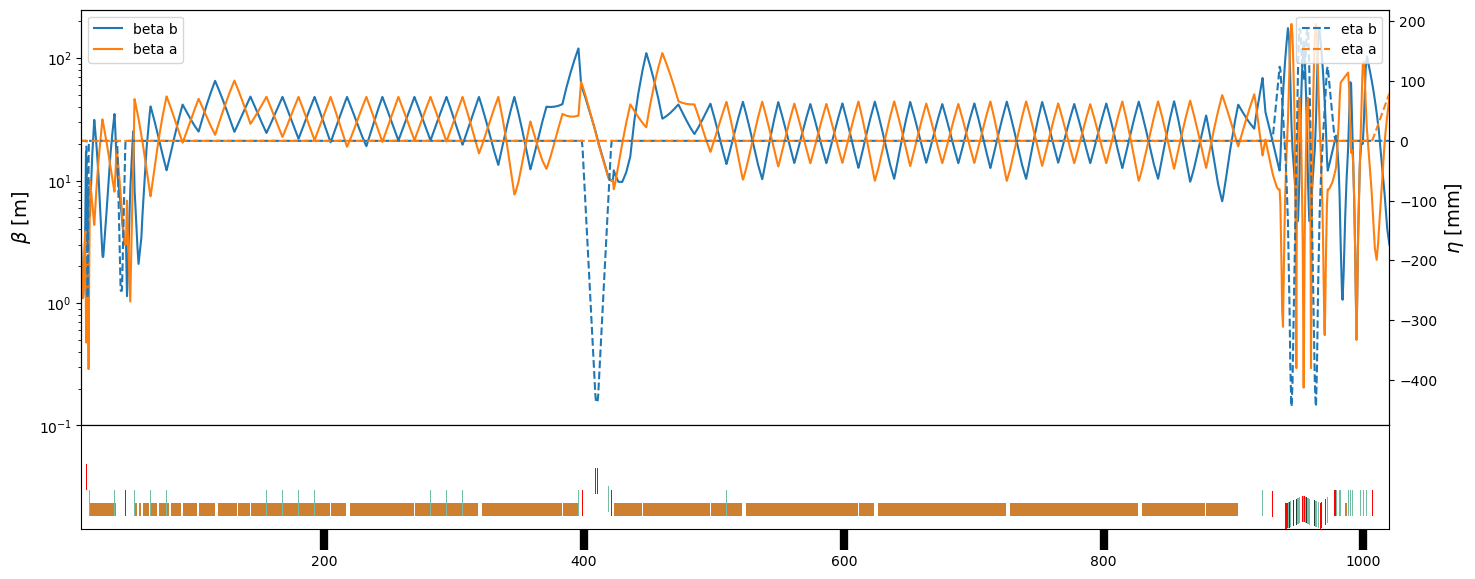

In [12]:
fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)

# Track particles

## Setup

In [13]:
#numMacroParticles = 100000
#tao.cmd(f"set beam_init n_particle = {numMacroParticles}") # limit to 10k particles for now

#Change tracking start/end
#tao.cmd('set beam_init track_end = ENDDL10')
tao.cmd('set beam_init track_end = PENT')
#Can see present track_start and track_end values with `show beam`



#Optional: Enable CSR
tao.cmd('call /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample/bmad/models/f2_elec/scripts/Activate_CSR.tao')
tao.cmd('csron')
#tao.cmd('csroff')

[]

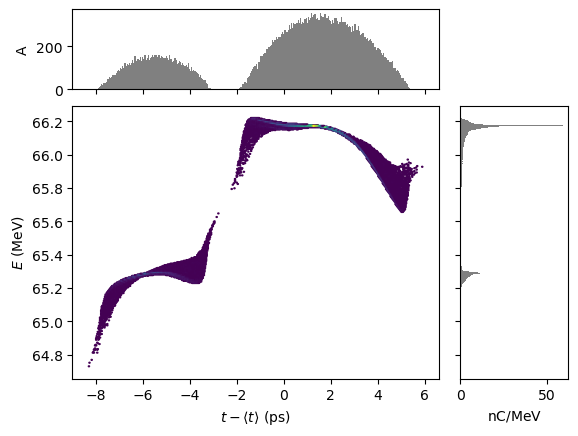

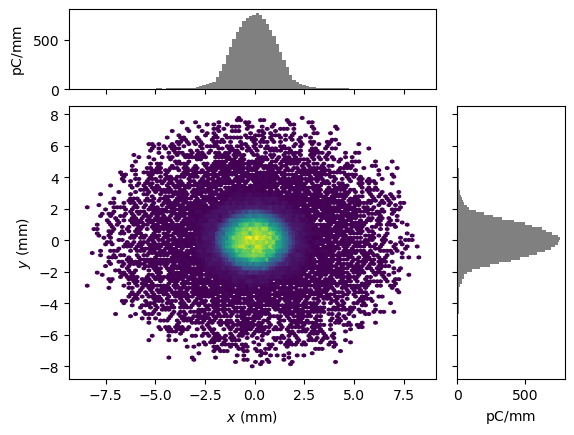

In [14]:
#P = ParticleGroup('/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample/bmad/beams/L0AFEND.h5')
#P = ParticleGroup('/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch.h5')
P = ParticleGroup('/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample.h5')

# === For original example beam ===
#P.data.update(resample_particles(P, n=numMacroParticles))

#P.gamma=P.gamma-np.mean(P.gamma)+tao.lat_list('L0AFEND','ele.e_tot')[0]*1e-6/0.511;
#P.twiss_match(plane='y',beta=tao.lat_list('L0AFEND','ele.a.beta'),alpha=tao.lat_list('L0AFEND','ele.a.alpha'),inplace=True)
#P.twiss_match(plane='x',beta=tao.lat_list('L0AFEND','ele.b.beta'),alpha=tao.lat_list('L0AFEND','ele.b.alpha'),inplace=True)

#print(P.twiss(plane='x'))
#print(P.twiss(plane='y'))

# === For 2024-02-16_2bunch ===
P.t=P.t-np.mean(P.t) #This is sloppy because beam weights are not used!!!

#numMacroParticles = 1000
#P.data.update(resample_particles(P, n=numMacroParticles))

P.write('/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample/bmad/beams/activeBeamFile.h5')


P.plot('delta_t', 'energy',bins=300)
P.plot('x', 'y',bins=100)

In [15]:
tao.cmd("set beam_init position_file = $FACET2_LATTICE/bmad/beams/activeBeamFile.h5")
print('Track start: ', tao.beam()['track_start'])
tao.beam_init()['position_file']

Track start:  L0AFEND


'$FACET2_LATTICE/bmad/beams/activeBeamFile.h5'

In [16]:
tao.beam_init()

{'position_file': '$FACET2_LATTICE/bmad/beams/activeBeamFile.h5',
 'sig_z_jitter': 0.0,
 'sig_pz_jitter': 0.0,
 'n_particle': 0,
 'renorm_center': True,
 'renorm_sigma': True,
 'random_engine': 'quasi',
 'random_gauss_converter': 'exact',
 'random_sigma_cutoff': -1.0,
 'a_norm_emit': 0.0,
 'b_norm_emit': 0.0,
 'a_emit': 0.0,
 'b_emit': 0.0,
 'dpz_dz': 0.0,
 'dt_bunch': 0.0,
 'sig_z': 0.0,
 'sig_pz': 0.0,
 'bunch_charge': 0.0,
 'n_bunch': 0,
 'species': '',
 'init_spin': True,
 'full_6d_coupling_calc': False,
 'use_particle_start': False,
 'use_t_coords': False,
 'use_z_as_t': False}

-40
9908.053794228053
-39
9902.967433424592
-38
9897.44369919667
-37
9890.831256270756
-36
9882.111704588338


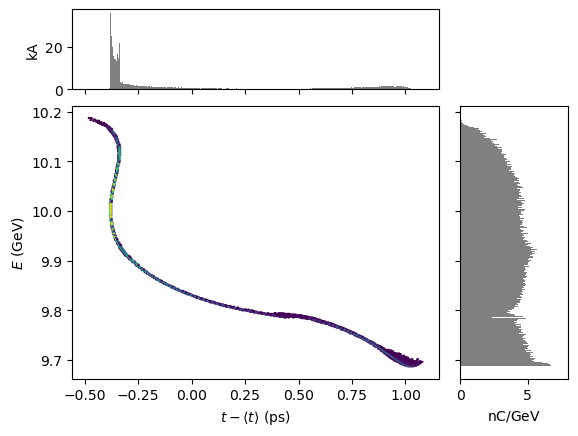

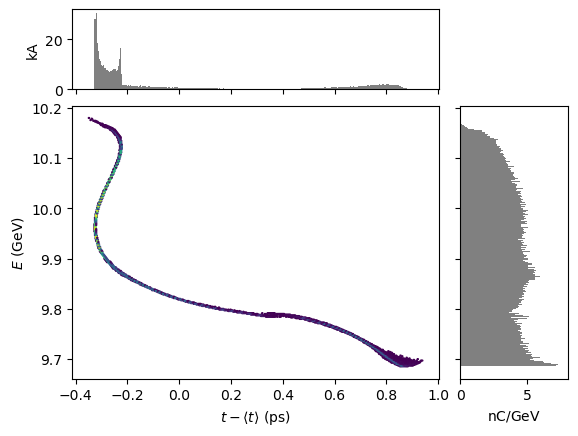

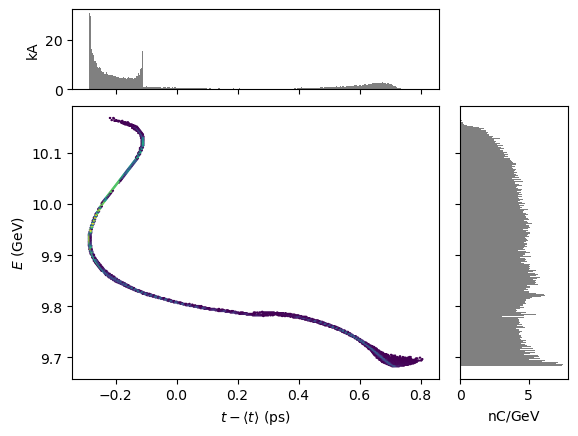

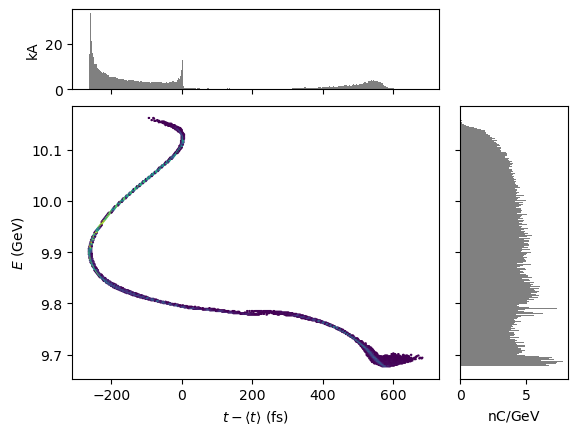

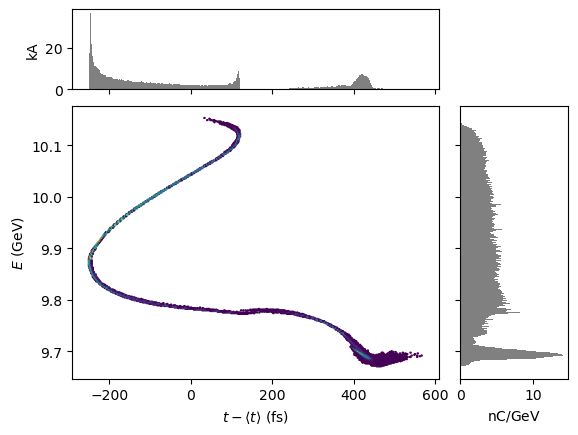

In [17]:
for L2AssertPHI0Deg in np.arange(-40,-35):
    #tao.cmd('set lattice model = design') #Undo any previous changes [Careful with this! It will turn things like CSR back off]
    
    # === Make changes to base lattice ===
    tao.cmd('set ele L0BF PHI0 = 0') #DNT. "loadNominalValues_2Bunch.m" had this set to zero
    tao.cmd('set ele L0BF VOLTAGE = 5.95e7') #DNT. Base value was 7.1067641E+07, new value set to change output energy to 125 MeV (down from 136.5 MeV)
    
    #Not positive how magnets react to having E_TOT changed
    #At the moment, only updating DL10 dipoles, neglect changing E_TOT elsewhere (including quads)
    #Hmmm, seems that (at least the SBEND BX10661) had its E_TOT automatically updated in response to my changes above
    #I appreciate that, but I'm nervous about how many moving and interconnected parts are that I'm not clear about how they're connecting
    #I can also confirm that the B_FIELD settings are automatically changed, leaving G
    
    L1AssertPHI0 = -19. / 360. #DNT. "loadNominalValues_2Bunch.m" had this set to -19 degrees
    tao.cmd(f'set ele K11_1* PHI0 = {L1AssertPHI0}')
    tao.cmd(f'set ele K11_2* PHI0 = {L1AssertPHI0}')
    L1AssertGradient = 1.25e7 #DNT. Set by trial and error to get 335 MeV
    tao.cmd(f'set ele K11_1* GRADIENT = {L1AssertGradient}')
    tao.cmd(f'set ele K11_2* GRADIENT = {L1AssertGradient}') #Beware! Old variables had non-uniform gradients?
    
    #This L2 is nonphysical; neglecting actuators, etc. Using gradient to set energy!
    L2AssertPHI0 = L2AssertPHI0Deg / 360. #DNT. "loadNominalValues_2Bunch.m" had this set to -37 degrees
    tao.cmd(f'set ele K11_4* PHI0 = {L2AssertPHI0}')
    tao.cmd(f'set ele K11_6* PHI0 = {L2AssertPHI0}')
    tao.cmd(f'set ele K12_* PHI0 = {L2AssertPHI0}')
    tao.cmd(f'set ele K13_* PHI0 = {L2AssertPHI0}')
    tao.cmd(f'set ele K14_* PHI0 = {L2AssertPHI0}')
    L2AssertGradient = 1.609e7 * np.cos(-37 * 3.1415/180) / np.cos(L2AssertPHI0Deg * 3.1415/180) #DNT. Set by trial and error to get 4.5 GeV
    tao.cmd(f'set ele K11_4* GRADIENT = {L2AssertGradient}')
    tao.cmd(f'set ele K11_6* GRADIENT = {L2AssertGradient}')
    tao.cmd(f'set ele K12_* GRADIENT = {L2AssertGradient}')
    tao.cmd(f'set ele K13_* GRADIENT = {L2AssertGradient}')
    tao.cmd(f'set ele K14_* GRADIENT = {L2AssertGradient}')
    
    
    #This L3 is nonphysical; neglecting actuators, etc. Using gradient to set energy!
    L3AssertGradient = 1.3e7 #DNT. Set by trial and error to get 10 GeV
    tao.cmd(f'set ele K15_* GRADIENT = {L3AssertGradient}')
    tao.cmd(f'set ele K16_* GRADIENT = {L3AssertGradient}')
    tao.cmd(f'set ele K17_* GRADIENT = {L3AssertGradient}')
    tao.cmd(f'set ele K18_* GRADIENT = {L3AssertGradient}')
    tao.cmd(f'set ele K19_* GRADIENT = {L3AssertGradient}')
    
    #A useful command to run in a console window with the same kernel
    #The lattice recalculates E_TOT at each of these `set` commands
    #    tao.cmd("show lat K11* -att GRADIENT -att E_TOT -att PHI0")
    #tao.cmd("show lat BEGBC14_1 -att E_TOT")
    #tao.cmd("show lat BEGBC20 -att E_TOT")
    
    tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
    tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
    
    P = ParticleGroup(data=tao.bunch_data('ENDBC20'))
    # Select out live particles
    P = P[P.status==1]
    P.drift_to_z()

    print(L2AssertPHI0Deg)
    print(np.mean(P.energy/1e6))
    P.plot('delta_t', 'energy',bins=300)
    #P.plot('x', 'y',bins=100)
    #P.slice_plot('norm_emit_x')